In [1]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from sklearn.metrics.pairwise import cosine_similarity

In [3]:
# Baixar e carregar o dataset pronto do TensorFlow
import tensorflow_datasets as tfds

dataset_name = "tf_flowers"
dataset, info = tfds.load(dataset_name, as_supervised=True, with_info=True)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [4]:
# Preparar dataset para treinamento
def format_image(image, label):
    image = tf.image.resize(image, (224, 224)) / 255.0
    return image, label

train_dataset = dataset['train'].map(format_image).batch(32)

In [5]:
# Modelo base (ResNet50)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Congelar pesos do modelo base


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [6]:
# Adicionar camadas customizadas
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation='relu')(x)
out = Dense(info.features['label'].num_classes, activation='softmax')(x)  # Ajustar para número de classes do dataset

model = Model(inputs=base_model.input, outputs=out)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [7]:
# Treinamento
model.fit(train_dataset, epochs=10)


Epoch 1/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 737s 6s/step - accuracy: 0.2999 - loss: 1.5891
Epoch 2/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 723s 6s/step - accuracy: 0.3933 - loss: 1.4556
Epoch 3/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 733s 6s/step - accuracy: 0.4235 - loss: 1.4169
Epoch 4/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 742s 6s/step - accuracy: 0.4362 - loss: 1.3868
Epoch 5/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 743s 6s/step - accuracy: 0.4489 - loss: 1.3598
Epoch 6/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 741s 6s/step - accuracy: 0.4571 - loss: 1.3365
Epoch 7/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 747s 6s/step - accuracy: 0.4655 - loss: 1.3153
Epoch 8/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 744s 6s/step - accuracy: 0.4774 - loss: 1.2962
Epoch 9/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 703s 6s/step - accuracy: 0.4813 - loss: 1.2780
Epoch 10/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 746s 6s/step - accuracy: 0.4892 - loss: 1.2603


In [17]:
# Criar modelo de extração de embeddings
embedding_model = Model(inputs=base_model.input, outputs=GlobalAveragePooling2D()(base_model.output))

def get_embedding(img):
    img = tf.image.resize(img, (224, 224)) / 255.0
    img = np.expand_dims(img, axis=0)
    return embedding_model.predict(img)

def find_similar_images(query_image, dataset, top_n=5):
    query_embedding = get_embedding(query_image)
    embeddings = np.array([get_embedding(img) for img, _ in dataset.take(100)])
    similarities = cosine_similarity(query_embedding, embeddings.reshape(len(embeddings), -1))
    top_indices = np.argsort(similarities[0])[-top_n:][::-1]
    similar_images = [dataset.take(100).skip(i).take(1) for i in top_indices]
    return similar_images, top_n # Return both similar_images and top_n


def display_images(query_image, similar_images_and_top_n):
    similar_images, top_n = similar_images_and_top_n  # Unpack the returned values
    plt.figure(figsize=(10, 5))
    plt.subplot(1, top_n + 1, 1)  # Use top_n here
    plt.imshow(query_image)
    plt.title("Imagem Consulta")
    plt.axis("off")

    for i, image_dataset in enumerate(similar_images):
        for image, _ in image_dataset:
            plt.subplot(1, top_n + 1, i + 2)  # Use top_n here
            plt.imshow(image)
            plt.title(f"Similar {i + 1}")
            plt.axis("off")
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

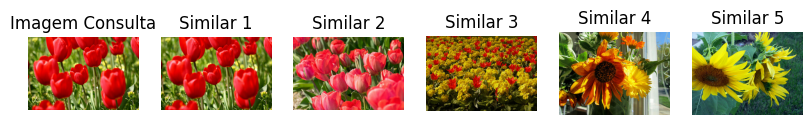

In [18]:
# Exemplo de uso
query_image, _ = next(iter(dataset['train']))  # Pegando uma imagem do dataset
similar_images = find_similar_images(query_image, dataset['train'])
display_images(query_image, similar_images)